# Coding Exercise 4: Job Search with Separation and Stochastic Offers

## Question 1: Discrete and IID Wage Offers



### The model

An unemployed worker receives with a probability $0 < \gamma < 1$ a wage offer $ w_t $, where $ \{w_t\} $ is IID and is drawn from a publicly known probability distribution $ q(w) $ from a set finite set $\mathbb{W} $ at each point in time.

Once receiving an offer at time $ t $, the unemployed worker has two options:

1. Accept the offer and work at constant wage $ w_t $ until she gets laid off.  
1. Reject the offer, receive unemployment compensation $ c $, and reconsider next period.  

Each period an employed worker faces a probability $\alpha$ of getting laid off and becoming unemployed. 

The agent is infinitely lived and aims to maximize the expected discounted sum of earnings

$$
\mathbb{E} \sum_{t=0}^{\infty} \beta^t y_t
$$

where 
- $ \beta \in (0, 1) $ is the discount factor.
- $ y_t $ is income, equal to
    - his/her wage $ w_t $ when employed  
    - unemployment compensation $ c $ when unemployed  

Let's denote $ V(w) $ and $ U $ the value of being employed at wage $w$ and the value of being unemployed, respectively. Then 

<a id='value_V'></a>
$$
V(w) = u(w) + \beta \Big[ (1-\alpha)V(w) + \alpha U \Big] \tag{1}
$$

and

<a id='value_U'></a>
$$
U = u(c) + \beta \left[(1-\gamma) U + \gamma \sum_{w' \in \mathbb W} \max\left\{V(w'), U\right\} q(w') \right] \tag{2}
$$


### Q.1-0: Import all external libraries that will used below.
    
- `numpy`, `numba`, `matplotlib` as usual
- `binom` from scipy.stats to generate wage offer distribution function in Q.1
- `brentq` from quantecon.optimize to solve the reservation wage in Q.2 

In [1]:
# your code here
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from quantecon.optimize import brentq
from numba import njit, float64
from numba.experimental import jitclass

### Q.1-1: Generate wage offer distribution

Suppose that the wage offers from a binomial distribution $B(n,p)$ with $n=50$ and $p=0.5$. Also assume that the set of possible wage offers has $n+1$ elements with the lowest wage is 10 and the highest wage is 40.

- Generate a vector `w` for wage offers and `q` for the probability for each wage offer. 
- plot `q` against `w`.

$$
X \sim B(n,p)\\
W = 10 + \alpha \cdot X\\
where\ \alpha = \frac{maxW - minW}{50}=\frac{40-10}{50}=0.6\\
\begin{align}
\text{support of }W = \mathbb{W} &= \{10, 10 + \alpha, 10 + 2\alpha, ..., 10+49\alpha, 10 + 50\alpha\}\\
&= \{10, 10.6, 11.2, ..., 39.4, 40\}\\
\end{align}\\
|\mathcal{S}_W| = 51
$$

In [2]:
np.linspace(start=10, stop=40, num=51)

array([10. , 10.6, 11.2, 11.8, 12.4, 13. , 13.6, 14.2, 14.8, 15.4, 16. ,
       16.6, 17.2, 17.8, 18.4, 19. , 19.6, 20.2, 20.8, 21.4, 22. , 22.6,
       23.2, 23.8, 24.4, 25. , 25.6, 26.2, 26.8, 27.4, 28. , 28.6, 29.2,
       29.8, 30.4, 31. , 31.6, 32.2, 32.8, 33.4, 34. , 34.6, 35.2, 35.8,
       36.4, 37. , 37.6, 38.2, 38.8, 39.4, 40. ])

<BarContainer object of 51 artists>

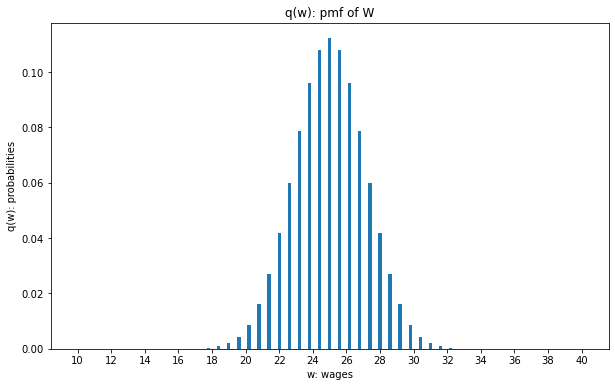

In [3]:
# your code here
np.random.seed(2015121120)
bi = binom(n=50, p=0.5)
sup_x = np.arange(51)
w =  10 + 0.6*sup_x
q = bi.pmf(sup_x)
plt.figure(figsize=(10,6))
plt.xticks(range(10, 41, 2))
plt.title('q(w): pmf of W')
plt.xlabel('w: wages')
plt.ylabel('q(w): probabilities')
# plt.plot(w, q, 'o-')
plt.bar(w,q, width=0.2)

### Q.1-2: Define the Class for the Model Economy

- specify types of the variables that are used in the class in `mccall_data`
- a function `__init__`: sets the default values for the data.
    - $\alpha = 0.1$: job separation rate
    - $\beta = 0.98$: discount factor
    - $\gamma = 0.7$: offer arrival rate
    - $\sigma = 2$: CRRA parameter
    - $c = 6$: unemployment compensation
- a function `u`: computes CRRA utility with parameter $\sigma$
- a function `update`: take V and U in the current as inputs and updates them according to equation (1) and (2) 
- jit-compile the class with `@jitclass`


In [4]:
# your code here
# With out numba
class McCallModel:
    def __init__(self, alpha=0.1, beta=0.98, gamma=0.7, sigma=2, c=6,
                 w=np.linspace(start=10, stop=40, num=51),
                 q=binom(n=50, p=0.5).pmf(np.arange(0,51)),
                ):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.sigma = sigma
        self.c = c
        self.w = w
        self.q = q
                
        assert len(self.w) == len(self.q), "Support and pmf have different number of values"

    
    def u(self, x):
        # Computes CRRA utility with parameter sigma
        out = (x ** (1 - self.sigma) - 1) / (1 - self.sigma)

        return out
    
    def update(self, V, U):
        # Take V and U in the current as inputs and updates them according to eq(1) and eq(2)
        # 𝑉(𝑤)=𝑢(𝑤)+𝛽[(1−𝛼)𝑉(𝑤)+𝛼𝑈] (1)
        # 𝑈=𝑢(𝑐)+𝛽[(1−𝛾)𝑈+𝛾∑𝑤′∈𝕎max{𝑉(𝑤′),𝑈}𝑞(𝑤′)] (2)
        
        alpha, beta, gamma, c, w, q = self.alpha, self.beta, self.gamma, self.c, self.w, self.q

        V_ = np.empty_like(V)
        
        for i in range(len(w)):
            V_[i] = self.u(w[i]) + beta * ((1 - alpha) * V[i] + alpha * U)

        # Note that U is a scalar value. 
        # unlike np.max, np.maximum() compares each elem in a vector V with a specific value U
        expect = np.dot(q, np.maximum(V, U))
        
        U_ = self.u(c) + beta * ((1 - gamma) * U + gamma * expect)
        
        return V_, U_
    
if __name__ == "__main__":
    m = McCallModel()
    u, v = m.update(np.arange(0,51), 1)

In [5]:
# your code here
# with numba
mccall_data = [
    ('alpha', float64),  # job separation rate
    ('beta', float64),   # discount factor
    ('gamma', float64),  # offer arrival rate
    ('sigma', float64),  # CRRA parameter
    ('c', float64),      # unemployment compensation
    ('w', float64[:]),   # list of wage values
    ('q', float64[:])    # pmf of random variable w
]

@jitclass(mccall_data)
class McCallModel:
    def __init__(self, alpha=0.1, beta=0.98, gamma=0.7, sigma=2, c=6,
                 w=np.linspace(10,40,51),
                 q=binom(50,0.5).pmf(np.arange(51))
                ):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.sigma = sigma
        self.c = c
        self.w = w
        self.q = q

        assert len(self.w) == len(self.q), "Support and pmf have different number of values"

    
    def u(self, x):
        # Computes CRRA utility with parameter sigma
        out = (x ** (1 - self.sigma) - 1) / (1 - self.sigma)

        return out
    
    def update(self, V, U):
        # Take V and U in the current as inputs and updates them according to eq(1) and eq(2)
        # 𝑉(𝑤)=𝑢(𝑤)+𝛽[(1−𝛼)𝑉(𝑤)+𝛼𝑈] (1)
        # 𝑈=𝑢(𝑐)+𝛽[(1−𝛾)𝑈+𝛾∑𝑤′∈𝕎max{𝑉(𝑤′),𝑈}𝑞(𝑤′)] (2)
        
        alpha, beta, gamma, c, w, q = self.alpha, self.beta, self.gamma, self.c, self.w, self.q
        
        V_ = np.empty_like(V)
        
        for i in range(len(w)):
            V_[i] = self.u(w[i]) + beta * ((1 - alpha) * V[i] + alpha * U)

        # Note that U is a scalar value. 
        # unlike np.max, np.maximum() compares each elem in a vector V with a specific value U    
        expect = np.sum(q * np.maximum(V, U))
        
        U_ = self.u(c) + beta * ((1 - gamma) * U + gamma * expect)
        
        return V_, U_

if __name__ == "__main__":
    m = McCallModel()
    m.update(np.arange(0,51), 1)

### Q.1-3: Solve Value Functions through Iteration

- Write a function `solve_model` that iterates the value functions V and U until they converge to their fixed points.
- jit-compile the function with `@njit`
- Create an instance `mcm` of the class `McCallModel` with the default values.
- solve for the fixed points of V and U.
- plot the converged V and U.


In [6]:
# your code here
@njit
def solve_model(mcm, tol=1e-5, max_iter=2000):
    # iterates the value functions V and U until they converge to their fixed points
    V = np.ones_like(mcm.w) # Initial guess of V
    U = 1 # Initial guess of U
    
    i = 0
    error = tol + 1
    
    while i < max_iter:
        # Update
        V_, U_ = mcm.update(V, U)
        
        # Calculate error
        error_V = np.max(np.abs(V_ - V))
        error_U = np.abs(U_ - U)
        error = max(error_V, error_U)
        
        # Update variables
        V, U = V_, U_
        i += 1
    
    return V, U

mcm = McCallModel()
value_e, value_u = solve_model(mcm)

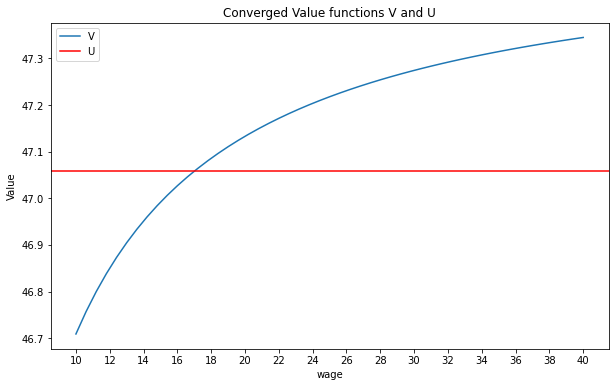

In [7]:
plt.figure(figsize=(10,6))
plt.xticks(range(10, 41, 2))
plt.title('Converged Value functions V and U')
plt.xlabel('wage')
plt.ylabel('Value')
plt.plot(mcm.w, value_e, label="V")
plt.axhline(value_u, label="U", c='red')
plt.legend()
plt.show()

### Q.1-4: Reservation Wage

- Write a function `compute_reservation_wage` to compute the reservation wage for the model economy.
- jit-compile the class with `@njit`
- execute the function to show the reservation wage. 

In [8]:
# your code here
@njit
def compute_reservation_wage(mcm):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that V(w) >= U.

    If no such w exists, then w_bar is set to np.inf.
    """

    value_e, value_u = solve_model(mcm)
        
    w_bar = np.inf
    for i, wage in enumerate(mcm.w):
        if value_e[i] > value_u:
            w_bar = wage
            break

    return w_bar

compute_reservation_wage(mcm)

17.2

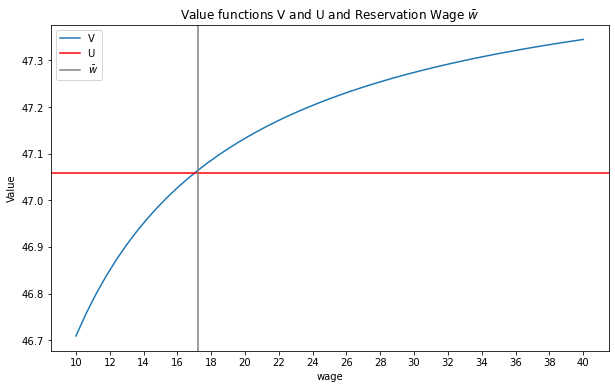

In [9]:
res_w = compute_reservation_wage(mcm)
plt.figure(figsize=(10,6))
plt.xticks(range(10, 41, 2))
plt.title('Value functions V and U and Reservation Wage '+r'$\bar{w}$')
plt.xlabel('wage')
plt.ylabel('Value')
plt.plot(mcm.w, value_e, label="V")
plt.axhline(value_u, label="U", c='red')
plt.axvline(res_w,label=r"$\bar{w}$", c='grey')
plt.legend()
plt.show()

### Q.1-5: Unemployment Rate in the Steady State

The steady state of the labor market in the model economy is the situation where flows between employment and unemployment are equal. Assuming the size of labor force being one, the inflow to unemployment is $\alpha (1-u)$ and outflow from unemployment is $f u$, where $f = \sum_{q\ge \bar w} q(w)$ is the job finding rate for an unemployed worker. Hence the unemployment rate in the steady state is:
$$
u^* = \frac{\alpha}{\alpha + f}
$$

- write a function `steady_state_unemployment` to compute the unemployment rate in the steady state.
- jit compile the function with `@njit`
- execute the function to show the the unemployment rate in the steady state.

In [10]:
# your code here
@njit
def steady_state_unemployment(mcm):
    # Compute the unemployment rate in the steady state
    w_bar = compute_reservation_wage(mcm)
    f = np.sum(mcm.q[np.where(mcm.w >= w_bar)])
    u_star = mcm.alpha / (mcm.alpha + f)
    
    return u_star

steady_state_unemployment(mcm)

0.09091281895044043

### Q.1-6: Average Unemployment Duration

- write a function `compute_average_unemployment_duration` to compute the average unemployment duration of 10,000 unemployed workers.
- the functioin should include functions `compute_stopping_time` to compute the unemployment duration of an unemployed worker and `compute_mean_stopping_time(num_reps=10000)` to simulate 10,000 unemployed workers.
- jit compile the inside functions with `@njit` and `@njit(parallel=True)`.
- execute the function to show the the average unemployment duration.


In [11]:
# your code here
from numba import prange

@njit(parallel=True)        
def compute_average_unemployment_duration(mcm):
    # Compute the average unemployment duration of 10,000 unemployed workers
    V, U = solve_model(mcm)
    res_wage = compute_reservation_wage(mcm)
    
    def compute_stopping_time():
        # Compute the unemployment duration of an unemployed worker
        unemployed = True
        t = 0
        
        while unemployed:
            # Draw current wage offer
            w = 10 + 0.6 * np.random.binomial(50,0.5)
            
            if w >= res_wage:
                unemployed = False
                return t
                
            else:
                t += 1

    def compute_mean_stopping_time(num_reps=10000):
        # Compute the meab stopping time
        sum_val = 0.0
        for i in prange(num_reps):
            sum_val += compute_stopping_time()
        out = sum_val / num_reps
        
        return out
    
    return compute_mean_stopping_time()

compute_average_unemployment_duration(mcm)

0.0

using the above codes that you wrote, compute the reservation wage, steady state unemployment rate, average unemployment duration for the model.

In [12]:
res_w = compute_reservation_wage(mcm)
u_star = steady_state_unemployment(mcm)
avg_drtn = compute_average_unemployment_duration(mcm)
print("Reservation wage: ", res_w)
print("Steady state unemployment rate: ", np.around(u_star, 4))
print("Average unemplyment duration: ", avg_drtn)

Reservation wage:  17.2
Steady state unemployment rate:  0.0909
Average unemplyment duration:  0.0


### Q.1-7: Comparative Statics: Reservation Wage

Show how reservation wages change as the model parameters change. 

- Use the values for parameters below.
- compute reservation wages and plot the results

In [13]:
grid_size = 25

α_vals = np.linspace(0.01, 0.8, grid_size)
γ_vals = np.linspace(0.4, 0.99, grid_size)
σ_vals = np.linspace(0.5, 3.0, grid_size)
wmax_vals = np.linspace(20, 60, grid_size)
c_vals = np.linspace(5, 20, grid_size)
p_vals = np.linspace(0.1, 0.9, grid_size)

# your code here
w_vals = np.array([np.linspace(10, w_max, 51) for w_max in wmax_vals])
q_vals = np.array([binom(50, p).pmf(np.arange(0, 51)) for p in p_vals])

params = {'alpha': α_vals,
          'gamma': γ_vals,
          'sigma': σ_vals,
          'w': w_vals,
          'c': c_vals,
          'q': q_vals,
         }

def get_output():
    results = {}

    for key, grid in params.items():
        
        res_wages = np.empty(len(grid))
        u_stars = np.empty(len(grid))
        durations = np.empty(len(grid))
        
        for i, value in enumerate(grid):
            m = McCallModel(**{key: value})
            res_wages[i] = compute_reservation_wage(m)
            u_stars[i] = steady_state_unemployment(m)
            durations[i] = compute_average_unemployment_duration(m)
            
            del m
            
        results.update({key: (res_wages, u_stars, durations)})
    
    return results

results = get_output()

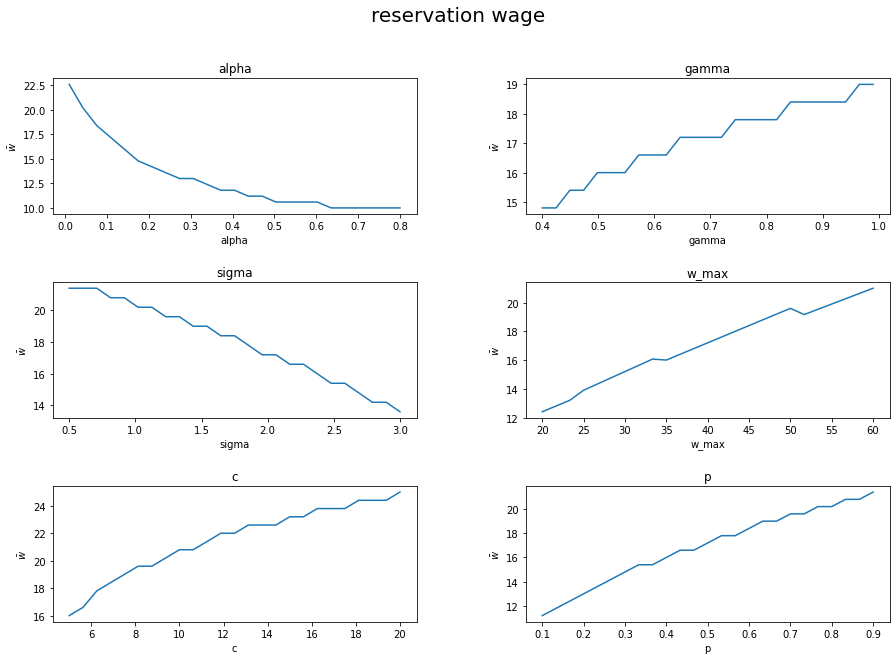

In [14]:
for_plot = {
    'alpha': (α_vals, results['alpha']),
    'gamma': (γ_vals, results['gamma']),
    'sigma': (σ_vals, results['sigma']),
    'w_max': (wmax_vals, results['w']),
    'c': (c_vals, results['c']),
    'p': (p_vals, results['q']),
}


fig, axs = plt.subplots(3,2, figsize=(15,10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
fig.suptitle("reservation wage", fontsize=20)
for i, (k, (x, result)) in enumerate(for_plot.items()):
    y = result[0]
    axs.flat[i].plot(x, y)
    axs.flat[i].set_title(k)
    axs.flat[i].set_xlabel(k)
    axs.flat[i].set_ylabel(r'$\bar{w}$')
plt.show()

### Q.1-8: Unemployment Rate in the Steady State

Show how the steady state unemployment rates change as the model parameters change. 

- Use the values for parameters as in Q.1-7.
- compute steady state unemployment rates and plot the results

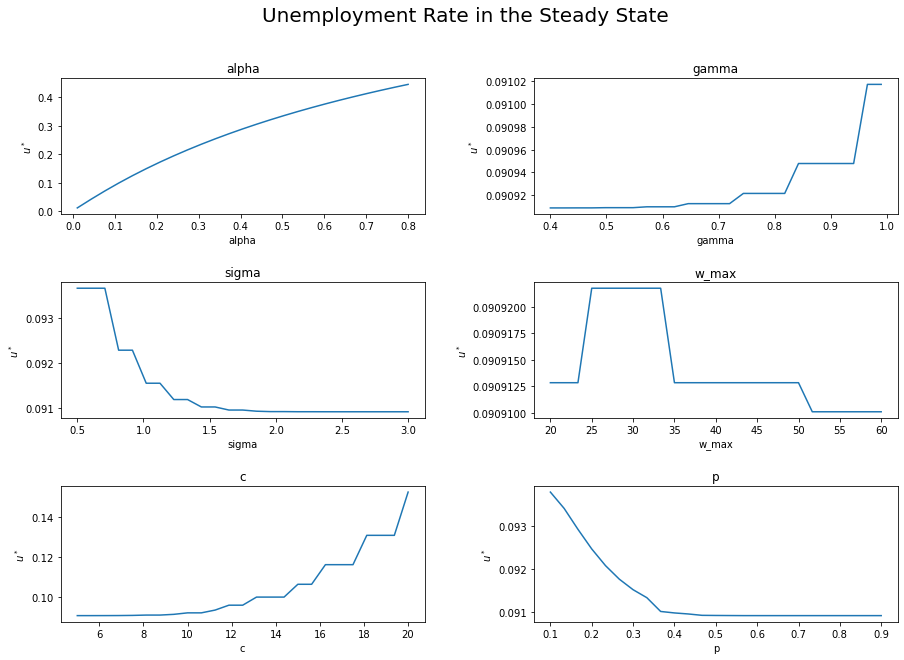

In [15]:
# your code here
fig, axs = plt.subplots(3,2, figsize=(15,10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
fig.suptitle("Unemployment Rate in the Steady State", fontsize=20)
for i, (k, (x, result)) in enumerate(for_plot.items()):
    y = result[1]
    axs.flat[i].plot(x, y)
    axs.flat[i].set_title(k)
    axs.flat[i].set_xlabel(k)
    axs.flat[i].set_ylabel(r'$u^*$')

### Q.1-9: Average Unemployment Duration

Show how the average unemployment durations change as the model parameters change. 

- Use the values for parameters as in Q.1-7.
- compute steady state unemployment rates and plot the results

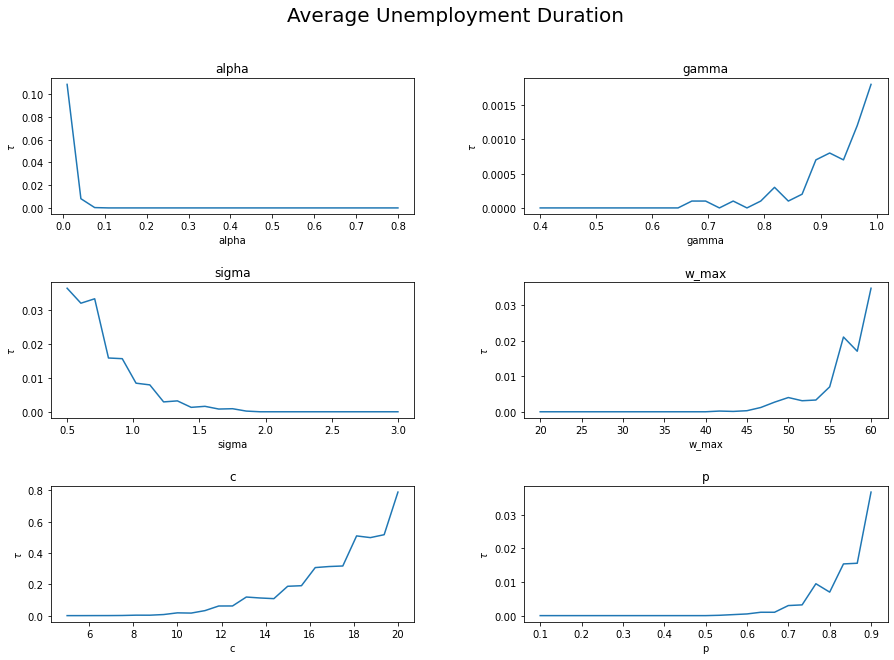

In [16]:
# your code here
fig, axs = plt.subplots(3,2, figsize=(15,10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
fig.suptitle("Average Unemployment Duration", fontsize=20)
for i, (k, (x, result)) in enumerate(for_plot.items()):
    y = result[2]
    axs.flat[i].plot(x, y)
    axs.flat[i].set_title(k)
    axs.flat[i].set_xlabel(k)
    axs.flat[i].set_ylabel(r'$\tau$')

## Question 2: Continuous and Correlated Wage Offers



### The model

Each period, an employed worker faces a probability $\alpha$ of getting laid off and becoming unemployed. If she survives the exogenous job separation, her wage changes according to a stochastic process of which transition probability distribution is given as $Q(w,w')=\mathrm{P}(w_{t+1}\le w'|w_t = w)$. Observing the wage change, an employed worker has two options:
1. Continues to work at the new wage $w'$: Stay employed
1. Quit the current job and search for a new job: Become unemployed.

For simplicity, assume that an unemployed worker is given UI benefits in the amount of $c$ and receives the wage offer $ \tilde{w} = \displaystyle{\int} w\, d\tilde{Q}(w) $ with a probability $0 < \gamma < 1$, where $\tilde{Q}(w')$ is the marginal distribution associated with $Q(\cdot, w')$. Since no other wage offers will be given, an nemployed worker immediately accepts the wage offer $ \tilde{w} $ once receving it and becomes employed. 

The value of being employed at wage $w$ and the value of being unemployed can be written as follow, respectively:  
<a id='value_V2'></a>
$$
V(w) = u(w) + \beta \Big[ (1-\alpha) \int \max\left\{V(w'), U\right\} q(w,w') dw' + \alpha U \Big] \tag{3}
$$

and

<a id='value_U2'></a>
$$
U = u(c) + \beta \left[(1-\gamma) U + \gamma V(\tilde{w}) \right] \tag{4}
$$

This setup is basically the same optimal stopping time problem. However it is now an **employed** worker's decision of quitting the current job instead of an unemployed worker's decision of taking a new job.

$$
\log{w_{t+1}} = \mu + \rho \log{w_t} + 
\epsilon_{t+1}, \qquad \epsilon_{t+1}\sim N(0,s)
$$

$$
\begin{align}
\log{w_{t+1}} &= \mu + \rho \log{w_t} + \epsilon_{t+1}\\
&= \mu + \rho (\mu + \rho \log{w_{t-1}} + \epsilon_{t}) + \epsilon_{t+1}\\
&= \mu + \rho \mu + \epsilon_{t+1} + \rho\epsilon_{t} + \rho^2 \log{w_{t-1}}\\
&= \mu + \rho \mu + \epsilon_{t+1} + \rho\epsilon_{t} + \rho^2 (\mu + \rho \log{w_{t-2}} + \epsilon_{t-1})\\
&= \mu + \rho \mu + \rho^2 \mu + \epsilon_{t+1} + \rho\epsilon_{t} + \rho^2\epsilon_{t-1} + \rho^3\log{w_{t-2}}\\
&\vdots\\
&= \{\mu + \rho \mu + \rho^2 \mu + \cdots\} + \{\epsilon_{t+1} + \rho\epsilon_{t} + \rho^2\epsilon_{t-1} + \cdots\}\\
&= \frac{\mu}{1-\rho} + \sum_{i=0}^{\infty} \rho^i \epsilon_{t+1-i} \\
\end{align}
$$
$$
\text{Note that }\epsilon_\tau \overset{\text{iid}}{\sim} N(0, s)\\
\text{Since }\log{w_{t+1}} \text{ is a linear combination of Normal random vaiables, }\log{w_{t+1}}\text{ is also a Normal random variable.}
$$
$$
\log{w} \sim N\left(\frac{\mu}{1-\rho}, \frac{s}{1-\rho^2}\right)\\
w \sim LogNormal \left(\frac{\mu}{1-\rho}, \frac{s}{1-\rho^2}\right)\\
$$

$$
\text{by the property of LogNormal distribution,}\\
\mu_w = E(w) = \log\left(\frac{\left(\frac{\mu}{1-\rho}\right)^2}{\sqrt{\left(\frac{s}{1-\rho^2}\right)+\left(\frac{\mu}{1-\rho}\right)^2}}\right)\\
\sigma_w^{2}=\log \left({\frac {\left(\frac{s}{1-\rho^2}\right)}{\left(\frac{\mu}{1-\rho}\right)^2}}+1\right)
$$

### Q.2-1: Define the class that describes the model economy

Write the class **QuitModel** assuming that wages follow the following AR(1) process: 

$$
\log{w_{t+1}} = \mu + \rho \log{w_t} + 
\epsilon_{t+1}, \qquad \epsilon_{t+1}\sim N(0,s)
$$. 

The contents of the class are similar to those in the class **McCallModel** in Q.1-2. 

- specify types of the variables that are used in the class in `quit_data`
- a function `__init__`: sets the default values for the data.
    - $\alpha = 0.1$: job separation rate
    - $\beta = 0.98$: discount factor
    - $\gamma = 0.7$: offer arrival rate
    - $\mu = 0$: drift term in AR(1) process of wages
    - $\rho = 0.9$: persistence of AR(1) process of wages
    - $s = 0.1$: variance of innovation in AR(1) process of wages
    - $\sigma = 2$: CRRA parameter
    - $c = 6$: unemployment compensation
    - grid_size = 100: length of wage grid vector
    - mc_size = 1,000: Monte Carlo draws for integration
- a function `u`: computes CRRA utility with parameter $\sigma$
- a function `update`: take V and U in the current as inputs and updates them according to equation (3) and (4) 
- jit-compile the class with `@jitclass`


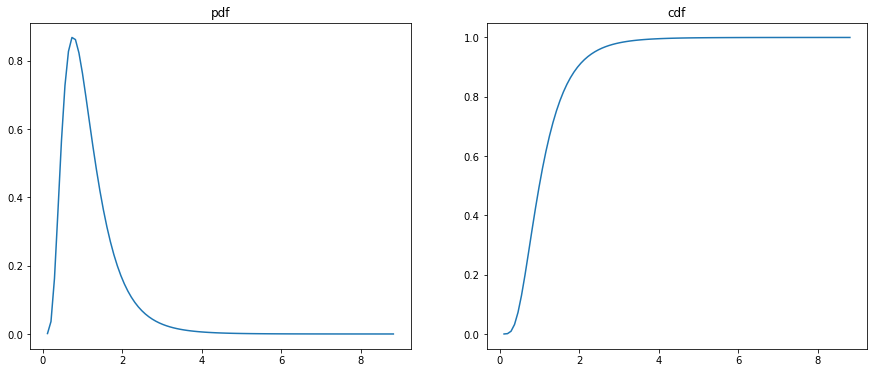

In [18]:
import scipy
lognorm = scipy.stats.lognorm(loc=qm.mu/(1-qm.rho), s=qm.s/(1-qm.rho**2))
fig, axs = plt.subplots(1,2, figsize=(15, 6))
axs.flat[0].plot(qm.w, lognorm.pdf(qm.w))
axs.flat[0].set_title('pdf')
axs.flat[1].plot(qm.w, lognorm.cdf(qm.w))
axs.flat[1].set_title('cdf')
plt.show()

In [17]:
# your code here
from numba import int64
from interpolation import interp
quit_data = [
    ('alpha', float64),   # job separation rate
    ('beta', float64),    # discount factor
    ('gamma', float64),   # offer arrival rate
    ('mu', float64),      # drift term in AR(1) process of wages
    ('rho', float64),     # persistence of AR(1) process of wages
    ('s', float64),       # variance of innovation in AR(1) process of wages
    ('sigma', float64),   # CRRA parameter
    ('c', float64),       # unemployment compensation
    ('grid_size', int64), # length of wage grid vector
    ('w', float64[:]),    # list of wage values
    ('mc_size', int64),    # Monte Carlo draws for integration
    ('eps_draws', float64[:]), # Monte Carlo draws for integration
]

@jitclass(quit_data)
class QuitModel:
    def __init__(self,
                 alpha=0.1,
                 beta=0.98,
                 gamma=0.7,
                 mu=0,
                 rho=0.9,
                 s=0.1,
                 sigma=2,
                 c=6,
                 grid_size=100,
                 mc_size=1000,
                ):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.rho = rho
        self.s = s
        self.sigma = sigma
        self.c = c
        self.grid_size = grid_size
        self.mc_size = mc_size
        
        logw_mean = mu/(1-rho)
        logw_sd = np.sqrt(s / (1-rho**2))
        grid_max = np.exp(logw_mean + 3 * logw_sd)
        grid_min = np.exp(logw_mean - 3 * logw_sd)
        self.w = np.linspace(grid_min, grid_max, grid_size)
        
        self.eps_draws = np.random.normal(0, np.sqrt(s), mc_size)
         
    def u(self, x):
        # Computes CRRA utility
        out = (x ** (1 - self.sigma) - 1) / (1 - self.sigma)

        return out
    
    def update(self, V, U):
        # take V and U in the current as inputs and updates them according to equation (3) and (4)
        alpha, beta, gamma, rho, mu, c, s = self.alpha, self.beta, self.gamma, self.rho, self.mu, self.c, self.s
        
        V_ = np.empty_like(V)
        w_tilde_sum = 0.0
        
        for i, w in enumerate(self.w):
            eps_draws = self.eps_draws
            
            w_ = np.exp(mu + rho * np.log(w) + eps_draws)
            w_tilde_sum += np.mean(w_)
            
            expect = np.mean(np.maximum(interp(self.w, V, w_), U))
            V_[i] = self.u(w) + beta * ((1 - alpha) * expect + alpha * U)
            
        # MC integration for w_tilde
        w_tilde = w_tilde_sum / len(self.w)
        U_ = self.u(c) + beta * ((1 - gamma) * U + gamma * interp(self.w, V, w_tilde))
        
        return V_, U_
    
    def f(self, x, V, U):
        return interp(self.w, V, x) - U

qm = QuitModel()

### Q.2-2: Solve Value Functions through Iteration

- Write a function `solve_model` that iterates the value functions V and U until they converge to their fixed points.
- jit-compile the function with `@njit`- Create an instance `qm` of the class `QuitModel` with the default values.
- solve for the fixed points of V and U.
- plot the converged V and U.


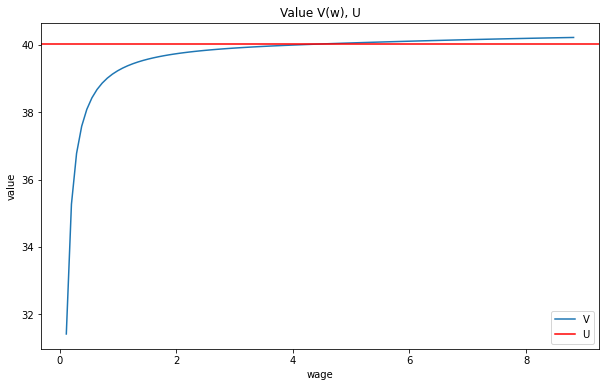

In [20]:
plt.figure(figsize=(10,6))
plt.title("Value V(w), U")
plt.plot(qm.w, V, label="V")
plt.xlabel('wage')
plt.ylabel('value')
plt.axhline(U, color='r', label="U")
plt.legend()
plt.show()

In [19]:
# your code here
@njit
def solve_model(m, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    * m is an instance of QuitModel
    """

    v = np.ones_like(m.w)    # Initial guess of v
    u = 1                           # Initial guess of d
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        v_new, u_new = m.update(v, u)
        error_1 = np.max(np.abs(v_new - v))
        error_2 = np.abs(u_new - u)
        error = max(error_1, error_2)
        v = v_new
        u = u_new
        i += 1

    return v, u
qm = QuitModel()
V, U = solve_model(qm)

### Q.2-3: Reservation Wage

- Write a function `compute_reservation_wage` to compute the reservation wage for the model economy using `brentq` from `quantecon.optimize`.
- jit-compile the class with `@njit`
- execute the function to show the reservation wage. 

In [21]:
# your code here
from quantecon.optimize import brentq
from interpolation import interp

@njit
def compute_reservation_wage(m):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that v(w) >= U.

    If no such w exists, then w_bar is set to np.inf.
    """
    value_V, value_U = solve_model(m)
    a, b = m.w[0], m.w[-1]
    results = brentq(m.f, a, b, args=(V, U), xtol=1e-5)
    return results.root

qm = QuitModel()
compute_reservation_wage(qm)

4.6676190696666815

### Q.2-4: Comparative Statics: Reservation Wage

Show how reservation wages change as the model parameters change. 

- Use the values for parameters below.
- compute reservation wages and plot the results

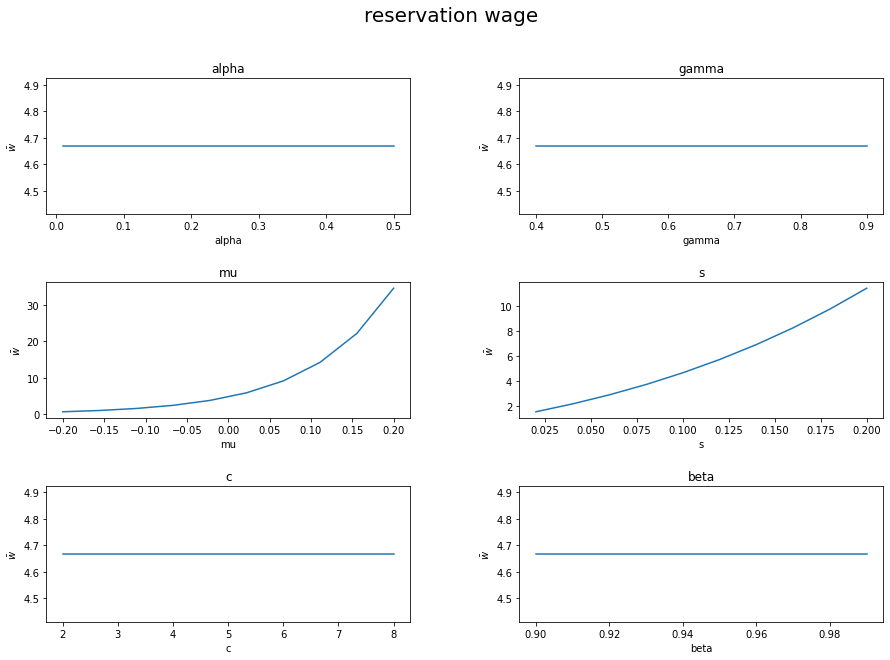

In [23]:
fig, axs = plt.subplots(3,2, figsize=(15,10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
fig.suptitle("reservation wage", fontsize=20)
for i, (k, result) in enumerate(results.items()):
    x = params[k]
    y = result
    axs.flat[i].plot(x, y)
    axs.flat[i].set_title(k)
    axs.flat[i].set_xlabel(k)
    axs.flat[i].set_ylabel(r'$\bar{w}$')
plt.show()

In [22]:
grid_size = 10

α_vals = np.linspace(0.01, 0.5, grid_size)
γ_vals = np.linspace(0.4, 0.9, grid_size)
μ_vals = np.linspace(-0.2, 0.2, grid_size)
s_vals = np.linspace(0.02, 0.2, grid_size)
c_vals = np.linspace(2, 8, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)


# your code here

params = {'alpha': α_vals,
          'gamma': γ_vals,
          'mu': μ_vals,
          's': s_vals,
          'c': c_vals,
          'beta': β_vals,
         }

def get_output():
    results = {}

    for key, grid in params.items():
        
        res_wages = np.empty(len(grid))
        
        for i, value in enumerate(grid):
            m = QuitModel(**{key: value})
            res_wages[i] = compute_reservation_wage(m)
            
            del m
            
        results.update({key: res_wages})
    
    return results

results = get_output()

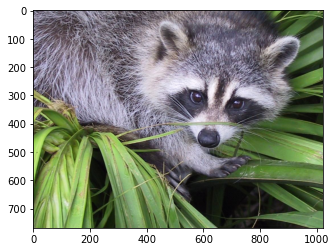

In [24]:
plt.imshow(scipy.misc.face())
plt.show()